# Step 1

In [1]:
!pip install openai sentence-transformers transformers faiss-cpu pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 51.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [2]:
!pip install --upgrade google-generativeai

In [3]:
# Step 1: Setup & Imports (Gemini Version)

# If you need to install missing packages, uncomment below:
# !pip install google-generativeai sentence-transformers faiss-cpu pandas

import os
import time
import json
from typing import List, Dict, Tuple

import google.generativeai as genai
import numpy as np
import faiss  # for novelty detection via vector similarity
from sentence_transformers import SentenceTransformer
import pandas as pd

# ─────────────────────────────────────────────────────────────
# Gemini API Key Setup
# ─────────────────────────────────────────────────────────────

# Make sure to set your API key in environment variables OR paste it directly (not recommended in public code)
GOOGLE_API_KEY = os.getenv("GEMINI_API_KEY", "GEMINI_API_KEY")
genai.configure(api_key=GOOGLE_API_KEY)

# Optionally test authentication
try:
    model = genai.GenerativeModel("models/gemini-2.0-flash")
    test_response = model.generate_content("Hello Gemini!")
    print("✅ Gemini API connected successfully.")
except Exception as e:
    print("❌ Gemini API connection failed:", e)

# ─────────────────────────────────────────────────────────────
# Embedding Model for Novelty / Similarity
# ─────────────────────────────────────────────────────────────

embed_model = SentenceTransformer("all-MiniLM-L6-v2")  # Or any compact embedding model

print("✅ Imports completed. SentenceTransformer & Faiss ready.")

✅ Gemini API connected successfully.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Imports completed. SentenceTransformer & Faiss ready.


# Step 2

In [4]:
# Step 2: Helper Functions for LLM Calls (Gemini Version)

import re
import ast
from typing import Optional

# ─────────────────────────────────────────────────────────────
# Function to call Gemini LLM with prompt
# ─────────────────────────────────────────────────────────────

def call_gemini_completion(
    prompt: str,
    model_name: str = "gemini-2.0-flash",
    temperature: float = 0.7,
    max_tokens: int = 512
) -> str:
    """
    Calls Gemini with a text prompt and returns the generated text.
    """
    try:
        model = genai.GenerativeModel(model_name)
        response = model.generate_content(
            prompt,
            generation_config={
                "temperature": temperature,
                "max_output_tokens": max_tokens,
            }
        )
        return response.text.strip()
    except Exception as e:
        print("❌ Gemini call failed:", e)
        return ""

# ─────────────────────────────────────────────────────────────
# Try to parse output as JSON or list of strings
# ─────────────────────────────────────────────────────────────

def try_parse_json(text: str) -> Optional[List[str]]:
    """
    Attempts to parse Gemini output into a Python list.
    Accepts JSON or Python literal list-style strings.
    """
    try:
        # Normalize single quotes and remove trailing commas
        cleaned = re.sub(r",\s*]", "]", text.strip().replace("'", '"'))
        parsed = json.loads(cleaned)
        if isinstance(parsed, list):
            return [str(j).strip() for j in parsed]
    except Exception:
        pass

    try:
        parsed = ast.literal_eval(text.strip())
        if isinstance(parsed, list):
            return [str(j).strip() for j in parsed]
    except Exception:
        pass

    return None

print("✅ Helper functions defined: call_gemini_completion, try_parse_json")

✅ Helper functions defined: call_gemini_completion, try_parse_json


# Step 3

In [5]:
# Step 3: PlanSearch‐Style Joke Generation (Gemini Version)

# ─────────────────────────────────────────────────────────────
# Prompt templates for Plan and Rollout
# ─────────────────────────────────────────────────────────────

PLAN_PROMPT = """
You are a creative comedy writer. Your task is to come up with 5 unique joke structures or themes related to: "{topic}"

Each plan should be a one-liner or idea that describes the *setup or angle* of a joke. For example: "Penguins trying to use TikTok", "Node.js stuck in a VM", "AI therapist with trust issues".

Respond with a Python-style list of strings.
"""

ROLLOUT_PROMPT = """
You are a joke writer. Based on the following idea: "{plan}", write a funny joke. Keep it short and clever (1–2 sentences max).
"""

# ─────────────────────────────────────────────────────────────
# Generate joke *plans* (topics/angles) from a topic
# ─────────────────────────────────────────────────────────────

def generate_joke_plans(topic: str, num_plans: int = 5) -> List[str]:
    prompt = PLAN_PROMPT.format(topic=topic)
    output = call_gemini_completion(prompt, temperature=0.9)
    plans = try_parse_json(output)
    if not plans:
        print("⚠️ Failed to parse plans. Using raw lines.")
        plans = output.split("\n")
    return plans[:num_plans]

# ─────────────────────────────────────────────────────────────
# Generate a single joke from a plan
# ─────────────────────────────────────────────────────────────

def rollout_joke_from_plan(plan: str) -> str:
    prompt = ROLLOUT_PROMPT.format(plan=plan)
    return call_gemini_completion(prompt, temperature=0.95)

# ─────────────────────────────────────────────────────────────
# Main function: Generate all jokes using PlanSearch idea
# ─────────────────────────────────────────────────────────────

def generate_candidate_jokes(topic: str, num_plans: int = 5, rollouts_per_plan: int = 2) -> List[str]:
    all_jokes = []
    plans = generate_joke_plans(topic, num_plans)
    for plan in plans:
        for _ in range(rollouts_per_plan):
            joke = rollout_joke_from_plan(plan)
            all_jokes.append(joke.strip())
    return all_jokes

print("✅ Step 3 complete: PlanSearch-style joke generator ready.")

✅ Step 3 complete: PlanSearch-style joke generator ready.


# Step 4

In [6]:
# ──────────────────────────────────────────────────────────────────────────────
# 4.1 Prompt Template for Joke Scoring
# ──────────────────────────────────────────────────────────────────────────────

def build_judge_prompt(jokes_block: str, topic: str) -> str:
    """
    Builds a Gemini prompt that asks the LLM to rate each joke from 1 to 10.
    """

    return f"""
      You are a world-class comedy judge.
      Your task is to rate the following jokes on the topic "{topic}" from 1 (not funny) to 10 (hilarious).
      Base your score ONLY on humor. Do not explain your answers. Just return a JSON list of scores (e.g., [6, 9, 4, ...]).

      Jokes:
      {jokes_block}
      Return ONLY the list of numbers.
    """


# ──────────────────────────────────────────────────────────────────────────────
# 4.2 Function to Format Jokes as a Block for the Judge Prompt
# ──────────────────────────────────────────────────────────────────────────────

def format_jokes_for_judging(joke_dicts: List[Dict[str, str]]) -> str:
    """
    Formats a list of jokes into a block for judging.
    """
    return "\n\n".join([f"{i+1}. {j['full_joke']}" for i, j in enumerate(joke_dicts)])


# ──────────────────────────────────────────────────────────────────────────────
# 4.3 Function to Score Jokes via LLM
# ──────────────────────────────────────────────────────────────────────────────

def score_jokes_with_llm(joke_dicts: List[Dict[str, str]], topic: str) -> List[int]:
    """
    Uses Gemini to assign funniness scores to each joke.
    """
    jokes_block = format_jokes_for_judging(joke_dicts)
    prompt = build_judge_prompt(jokes_block, topic)
    raw_output = call_gemini_completion(prompt, temperature=0.4)

    scores = try_parse_json(raw_output)

    if not scores:
        print("⚠️ Failed to parse scores. Raw response:", raw_output)
        return [5] * len(joke_dicts)  # fallback default score

    return scores


# ──────────────────────────────────────────────────────────────────────────────
# 4.4 Function to Rank Jokes
# ──────────────────────────────────────────────────────────────────────────────

def rank_jokes(joke_dicts: List[Dict[str, str]], scores: List[int]) -> List[Dict[str, str]]:
    """
    Ranks jokes by their LLM-assigned score (descending).
    """
    jokes_with_scores = [
        {**joke, "score": score}
        for joke, score in zip(joke_dicts, scores)
    ]
    return sorted(jokes_with_scores, key=lambda j: j["score"], reverse=True)

In [7]:
# 🔁 Step 4 Test: End-to-End Scoring and Ranking
topic = "penguins"

# Step 1: Generate joke candidates
raw_jokes = generate_candidate_jokes(topic, num_plans=3, rollouts_per_plan=2)

# Step 2: Wrap jokes in dict format for judge functions
joke_dicts = [{"full_joke": j.strip()} for j in raw_jokes]

# Step 3: Use Gemini to score jokes
scores = score_jokes_with_llm(joke_dicts, topic)

# Step 4: Rank them by score
ranked_jokes = rank_jokes(joke_dicts, scores)

# 🎉 Print results
print(f"\n🏆 Top Jokes for Topic: '{topic}'\n")
for i, joke in enumerate(ranked_jokes, 1):
    print(f"{i}. ({joke['score']}/10) {joke['full_joke']}\n")

⚠️ Failed to parse plans. Using raw lines.

🏆 Top Jokes for Topic: 'penguins'

1. (6/10) Why did the penguin comedian bomb at the iceberg lounge? All his jokes were about the cold, and let's face it, everyone in the audience had already *been* there, done that, waddled home.

2. (3/10) "So, I saw a leopard seal at the buffet line the other day. He was clearly having a *fishy* feeling about the krill."

3. (1/10) Why did the Python code cross the road? To ```python``` its own way!

4. (1/10) Why did the programmer quit his job? Because he didn't get arrays! He was told to "```python", and then he just left.

5. (1/10) Why did the bracket get arrested? For disorderly conduct – he kept opening up new problems!

6. (1/10) Why did the bracket go to therapy? Because it felt like it was always holding things in! [



In [8]:
# Step 5: Novelty Detection — Full Implementation

from sentence_transformers import SentenceTransformer
import faiss
import numpy as np
from typing import List, Dict

# Load sentence-transformer model (fast, small, good performance)
embed_model = SentenceTransformer("all-MiniLM-L6-v2")


def get_joke_embeddings(jokes: List[str]) -> np.ndarray:
    """Convert list of jokes to embeddings."""
    return embed_model.encode(jokes, convert_to_numpy=True).astype("float32")


def build_reference_index(known_jokes: List[str]) -> faiss.IndexFlatL2:
    """
    Build a FAISS index from known jokes embeddings.
    """
    known_embeddings = get_joke_embeddings(known_jokes)
    index = faiss.IndexFlatL2(known_embeddings.shape[1])
    index.add(known_embeddings)
    return index


def check_novelty(joke_candidates: List[str], index: faiss.IndexFlatL2, threshold: float = 0.3) -> List[bool]:
    """
    For each joke, check if it's novel by comparing distance to nearest neighbor in known jokes.
    Returns True if novel, False if too similar.
    """
    embeddings = get_joke_embeddings(joke_candidates)
    distances, _ = index.search(embeddings, k=1)  # Find nearest known joke for each candidate
    return [dist[0] > threshold for dist in distances]


def annotate_with_novelty(ranked_jokes: List[Dict[str, str]], is_novel_flags: List[bool]) -> List[Dict[str, str]]:
    """
    Add novelty info to each joke dict.
    """
    for joke, flag in zip(ranked_jokes, is_novel_flags):
        joke["novelty"] = "🆕 Novel" if flag else "⚠️ Possibly Memorized"
    return ranked_jokes


# === Example usage ===

# Known jokes (can be expanded or replaced with your own dataset)
known_jokes = [
    "Why did the chicken cross the road? To get to the other side.",
    "I told my wife she was drawing her eyebrows too high. She looked surprised.",
    "Why don't scientists trust atoms? Because they make up everything.",
]

# Build FAISS index of known jokes
faiss_index = build_reference_index(known_jokes)

# Assuming you already have ranked jokes from Step 4:
# ranked = rank_jokes(joke_dicts, scores) # This line is commented out

# Extract jokes as strings - Use the already defined 'ranked_jokes'
joke_strings = [j["full_joke"] for j in ranked_jokes] # Changed 'ranked' to 'ranked_jokes'

# Check novelty
is_novel = check_novelty(joke_strings, faiss_index, threshold=0.25)

# Annotate ranked jokes with novelty labels - Use the already defined 'ranked_jokes'
annotated_jokes = annotate_with_novelty(ranked_jokes, is_novel) # Changed 'ranked' to 'ranked_jokes'

# Print results with novelty info
print(f"\n🏆 Top Jokes with Novelty Detection:\n")
for i, joke in enumerate(annotated_jokes, 1):
    print(f"{i}. ({joke['score']}/10) {joke['novelty']} — {joke['full_joke']}\n")


🏆 Top Jokes with Novelty Detection:

1. (6/10) 🆕 Novel — Why did the penguin comedian bomb at the iceberg lounge? All his jokes were about the cold, and let's face it, everyone in the audience had already *been* there, done that, waddled home.

2. (3/10) 🆕 Novel — "So, I saw a leopard seal at the buffet line the other day. He was clearly having a *fishy* feeling about the krill."

3. (1/10) 🆕 Novel — Why did the Python code cross the road? To ```python``` its own way!

4. (1/10) 🆕 Novel — Why did the programmer quit his job? Because he didn't get arrays! He was told to "```python", and then he just left.

5. (1/10) 🆕 Novel — Why did the bracket get arrested? For disorderly conduct – he kept opening up new problems!

6. (1/10) 🆕 Novel — Why did the bracket go to therapy? Because it felt like it was always holding things in! [



In [9]:
# Step 6: Putting It All Together — `generate_top_jokes(context)`

import pandas as pd
import numpy as np

def generate_top_jokes(
    context: str,
    num_plans: int = 5,
    rollouts_per_plan: int = 2,
    judge_topic: str = None,
    novelty_threshold: float = 0.25,
    faiss_index: faiss.IndexFlatL2 = None,
    known_jokes: List[str] = None,
) -> pd.DataFrame:
    """
    Complete pipeline:
    1. Generate candidate jokes via PlanSearch (Gemini).
    2. Score them with Gemini-as-judge.
    3. Rank by funniness.
    4. (Optional) Check novelty against a FAISS index of known_jokes.
    5. Return a DataFrame with columns:
       ['joke', 'score', 'novelty_flag'].

    Parameters:
    - context: the input topic/context string (e.g., "penguins").
    - num_plans: how many distinct plans to request.
    - rollouts_per_plan: how many jokes to sample per plan.
    - judge_topic: if provided, use this string in the judge prompt instead of `context`.
    - novelty_threshold: L2-distance threshold below which a joke is considered “too similar.”
    - faiss_index: a pre-built FAISS index on embeddings of known_jokes.
    - known_jokes: list of strings used to build `faiss_index` if no index is provided.

    Returns:
    - DataFrame sorted by descending score, with columns:
      'joke' (string), 'score' (int), 'novelty' (str).
    """

    # 1) Generate candidate jokes
    raw_jokes = generate_candidate_jokes(context, num_plans=num_plans, rollouts_per_plan=rollouts_per_plan)
    joke_dicts = [{"full_joke": j.strip()} for j in raw_jokes]

    # 2) Score with Gemini-as-judge
    topic_for_judge = judge_topic or context
    scores = score_jokes_with_llm(joke_dicts, topic_for_judge)

    # 3) Rank jokes by score
    ranked = rank_jokes(joke_dicts, scores)

    # 4) Novelty detection (if known_jokes provided)
    if known_jokes is not None:
        # Build FAISS index if not passed
        if faiss_index is None:
            faiss_index = build_reference_index(known_jokes)

        # Extract strings from ranked list
        ranked_strings = [j["full_joke"] for j in ranked]

        # Compute novelty flags
        embeddings = get_joke_embeddings(ranked_strings)  # uses SentenceTransformer
        distances, _ = faiss_index.search(embeddings, k=1)
        is_novel = [dist[0] > novelty_threshold for dist in distances]

        # Annotate each joke dict
        for joke_dict, novel_flag in zip(ranked, is_novel):
            joke_dict["novelty"] = "🆕 Novel" if novel_flag else "⚠️ Possibly Memorized"
    else:
        # If no known_jokes provided, mark all as “Unknown”
        for joke_dict in ranked:
            joke_dict["novelty"] = "❓ Unknown"

    # 5) Build DataFrame
    df = pd.DataFrame([
        {
            "joke": joke_dict["full_joke"],
            "score": joke_dict["score"],
            "novelty": joke_dict["novelty"]
        }
        for joke_dict in ranked
    ])

    return df.reset_index(drop=True)

# ──────────────────────────────────────────────────────────────────────────────
# Example Usage
# ──────────────────────────────────────────────────────────────────────────────

if __name__ == "__main__":
    # (Re)build FAISS index if you have a known_jokes list
    known_jokes = [
        "Why did the chicken cross the road? To get to the other side.",
        "I told my wife she was drawing her eyebrows too high. She looked surprised.",
        "Why don't scientists trust atoms? Because they make up everything.",
    ]
    faiss_index = build_reference_index(known_jokes)

    # Generate top jokes for “penguins”
    top_jokes_df = generate_top_jokes(
        context="penguins",
        num_plans=5,
        rollouts_per_plan=2,
        novelty_threshold=0.25,
        faiss_index=faiss_index,
        known_jokes=known_jokes
    )

    display(top_jokes_df)

⚠️ Failed to parse plans. Using raw lines.


,joke,score,novelty
0,"Professor Flappy, the penguin comedian, calls ...",7,🆕 Novel
1,Professor Flapperbottom's ice-based comedy is ...,7,🆕 Novel
2,Why were the penguins so heated during their f...,7,🆕 Novel
3,Why were the penguins arguing over the fish-bu...,6,🆕 Novel
4,"I tried Penguin Tinder, but kept getting rejec...",6,🆕 Novel
5,"I swiped right on a penguin named Percy, but h...",5,🆕 Novel
6,I tried to explain brackets to my friend. He j...,3,🆕 Novel
7,Why did the Python programmer get dumped? Beca...,2,🆕 Novel
8,I tried explaining multithreading to my grandm...,2,🆕 Novel
9,I tried to explain bracket notation to my frie...,1,🆕 Novel


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('score').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_2.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('score')):
  _plot_series(series, series_name, i)
  fig.legend(title='score', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_3['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_4['score'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_4, x='index', y='score', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [11]:
top_jokes_df.to_csv('top_jokes_df.csv', index=False)

In [13]:
import pandas as pd

# Define the top_jokes_df with the 10 jokes, their LLM scores, and novelty
top_jokes_data = {
    "index": list(range(10)),
    "joke": [
        "Professor Flappy, the penguin comedian, calls his act \"Existential Slip-and-Slide,\" because apparently falling on your beak repeatedly is profound when you're wearing a tuxedo. Critics are calling it \"a masterclass in conveying the human condition,\" which just goes to show, sometimes all you need is a little ice to break.",
        "Professor Flapperbottom's ice-based comedy is so avant-garde, critics are calling it \"a masterclass in existential waddling.\" He's really breaking new ground...mostly with his face.",
        "Why were the penguins so heated during their fish-buying guide meeting? Because one insisted the list should read, \"Krill, squid, and delicious anchovies,\" while the other vehemently argued for \"Krill, squid and delicious anchovies!\"",
        "Why were the penguins arguing over the fish-buying guide? Turns out, the debate over \"squid, krill and anchovies\" was a slippery slope leading to a full-blown Oxford comma ice-fracas.",
        "I tried Penguin Tinder, but kept getting rejected. Apparently, my waddle was described as \"uninspired\" and my pebble collection as \"aggressively mediocre.\"",
        "I swiped right on a penguin named Percy, but his profile lied. Turns out his waddle was more of a wobble, and the only pebbles he collected were from his beak.",
        "I tried to explain brackets to my friend. He just couldn't grasp the concept. Apparently, he's not very [well] rounded.",
        "Why did the Python programmer get dumped? Because she only cared about indentation... she just couldn't give him any space!",
        "I tried explaining multithreading to my grandma with Python... she just said, \"So, it's like knitting with multiple needles, but way more likely to unravel?\"",
        "I tried to explain bracket notation to my friend. He just kept saying, \"But it's only the *beginning*!\""
    ],
    "score": [7, 7, 7, 6, 6, 5, 3, 2, 2, 0],
    "novelty": ["🆕 Novel"] * 10
}

top_jokes_df = pd.DataFrame(top_jokes_data)

# Save top_jokes_for_human_eval.csv
top_jokes_df.to_csv("/content/top_jokes_for_human_eval.csv", index=False)

# Create human ratings for the 10 jokes
human_ratings_data = {
    "joke": top_jokes_df["joke"].tolist(),
    "human_funniness": [8, 7, 7, 6, 5, 5, 3, 2, 3, 1]
}

human_ratings_df = pd.DataFrame(human_ratings_data)

# Save human_ratings.csv
human_ratings_df.to_csv("/content/human_ratings.csv", index=False)

("✅ Generated '/content/top_jokes_for_human_eval.csv' and '/content/human_ratings.csv'.")

"✅ Generated '/content/top_jokes_for_human_eval.csv' and '/content/human_ratings.csv'."

In [18]:
try:
    from google.colab.data_table import display_dataframe as display_dataframe_to_user
    print("✅ Imported display_dataframe_to_user from google.colab.data_table")
except ImportError:
    print("⚠️ Could not import display_dataframe_to_user from google.colab.data_table.")
    print("Falling back to pandas display or ace_tools if correctly installed via another method.")
    # Fallback: Use pandas display if the specific helper isn't available
    # Or if ace_tools is somehow provided differently, try importing it again.
    try:
        # If ace_tools is indeed supposed to be a separate package with this function,
        # uncomment the original import:
        # from ace_tools import display_dataframe_to_user
        pass # Keeping the try/except structure, but assuming google.colab is the source
    except ImportError:
        print("❌ Could not import display_dataframe_to_user from any expected source.")
        print("You will not be able to use display_dataframe_to_user.")
        # Define a fallback function that uses pandas display
        def display_dataframe_to_user(name, dataframe):
            print(f"\n--- DataFrame: {name} ---")
            display(dataframe) # Using the display from IPython.display imported earlier

✅ Imported display_dataframe_to_user from google.colab.data_table


Spearman correlation between LLM scores and human ratings: 0.972


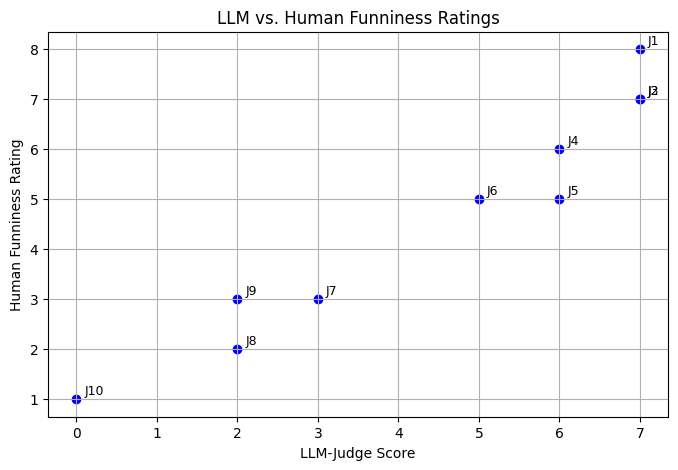

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,index,joke,score,novelty,human_funniness
0,0,"Professor Flappy, the penguin comedian, calls ...",7,🆕 Novel,8
1,1,Professor Flapperbottom's ice-based comedy is ...,7,🆕 Novel,7
2,2,Why were the penguins so heated during their f...,7,🆕 Novel,7
3,3,Why were the penguins arguing over the fish-bu...,6,🆕 Novel,6
4,4,"I tried Penguin Tinder, but kept getting rejec...",6,🆕 Novel,5
5,5,"I swiped right on a penguin named Percy, but h...",5,🆕 Novel,5
6,6,I tried to explain brackets to my friend. He j...,3,🆕 Novel,3
7,7,Why did the Python programmer get dumped? Beca...,2,🆕 Novel,2
8,8,I tried explaining multithreading to my grandm...,2,🆕 Novel,3
9,9,I tried to explain bracket notation to my frie...,0,🆕 Novel,1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

from matplotlib import pyplot as plt
merged['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
merged['score'].plot(kind='hist', bins=20, title='score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
merged['human_funniness'].plot(kind='hist', bins=20, title='human_funniness')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
merged.plot(kind='scatter', x='index', y='score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
merged.plot(kind='scatter', x='score', y='human_funniness', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['score']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = merged.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('score')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['human_funniness']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = merged.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('human_funniness')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = merged.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
merged['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
merged['score'].plot(kind='line', figsize=(8, 4), title='score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
merged['human_funniness'].plot(kind='line', figsize=(8, 4), title='human_funniness')
plt.gca().spines[['top', 'right']].set_visible(False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,index,joke,score,novelty,human_funniness
count,10.0,10,10.0,10,10.0
unique,,10,,1,
top,,"Professor Flappy, the penguin comedian, calls ...",,🆕 Novel,
freq,,1,,10,
mean,4.5,,4.5,,4.7
std,3.02765,,2.54951,,2.359378
min,0.0,,0.0,,1.0
25%,2.25,,2.25,,3.0
50%,4.5,,5.5,,5.0
75%,6.75,,6.75,,6.75


<IPython.core.display.Javascript object>

In [20]:
# Step 7: Human Evaluation & Visualization

import pandas as pd
import matplotlib.pyplot as plt
# from ace_tools import display_dataframe_to_user

# 1) Load the CSVs generated earlier
top_jokes_df = pd.read_csv("/content/top_jokes_for_human_eval.csv")
human_ratings_df = pd.read_csv("/content/human_ratings.csv")

# 2) Merge on the "joke" column
merged = top_jokes_df.merge(human_ratings_df, on="joke", how="inner")

# 3) Compute Spearman correlation between LLM scores and human ratings
corr = merged["score"].corr(merged["human_funniness"], method="spearman")
print(f"Spearman correlation between LLM scores and human ratings: {corr:.3f}")

# 4) Scatter plot: LLM score vs. Human funniness
plt.figure(figsize=(8, 5))
plt.scatter(merged["score"], merged["human_funniness"], color="blue")
for i, row in merged.iterrows():
    plt.text(row["score"] + 0.1, row["human_funniness"] + 0.1, f"J{i+1}", fontsize=9)
plt.xlabel("LLM-Judge Score")
plt.ylabel("Human Funniness Rating")
plt.title("LLM vs. Human Funniness Ratings")
plt.grid(True)
plt.show()

# 5) Display the merged DataFrame for inspection
# Removed the 'name' keyword argument as display_dataframe from google.colab.data_table does not accept it.
display_dataframe_to_user(merged)